## Policy Gradient Implementations - REINFORCE with Average MC return baseline

In [6]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gym import wrappers
from torch.distributions import Categorical
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:

class PolicyNetwork(nn.Module):  
    def __init__(self,num_states, num_actions, hidden_size):
        super(PolicyNetwork,self).__init__()
        self.num_states = num_states
        self.num_actions = num_actions
        
        #Policy Network
        self.policy_linear1 = nn.Linear(num_states,hidden_size)
        self.policy_linear2 = nn.Linear(hidden_size,num_actions)
        
        
    def forward(self,state):
        x1 = self.policy_linear1(state)
        x1 = F.relu(x1)
        x1 = self.policy_linear2(x1)
        policy_out = F.softmax(x1,dim=1)
        
        return policy_out


    
    

In [8]:
def update_gradients(gamma,ep_rewards,ep_logits,ep_entropies):
    mc_return = []
    p_loss = []
    loss=0
    G = 0
    for r in reversed(range(len(ep_rewards))):
        G = ep_rewards[r] + gamma*G
        mc_return.insert(0,G)
    mc_return = torch.tensor(mc_return)
    advantage_returns = (mc_return - mc_return.mean())/mc_return.std()
    #print((mc_return))
    for lp, re in zip(ep_logits, advantage_returns):
        p_loss.append( - lp * re)
    optim_policy.zero_grad() 
    #trying entropy regularization
    loss = torch.stack(p_loss).sum() + 0.001*ep_entropies
    loss.backward()
    optim_policy.step()

    
    

In [9]:
def train(env):
    gamma = 0.99
    max_episodes = 2000
    max_steps = 10000
    running_reward = 0
    plot_rewards = []
    for ep in range(max_episodes):
        ep_rewards =[]
        ep_logits = []
        ep_entropies = []

        current_reward = 0
        state = env.reset()
        
        for step in range(max_steps):
            #print(type(state))
            state = torch.from_numpy(state).float().unsqueeze(0)
            policy_softmax = p_net.forward(state)
            
            #Sample next action with current stochastic policy
            
            dist_obj = Categorical(policy_softmax)
            action = dist_obj.sample()
            #calculate log probability
            log_prob = dist_obj.log_prob(action)
            #calculate entropy
            entropy = torch.sum(-policy_softmax*torch.log(policy_softmax))
            #Render environment with sampled action
            state,reward,done,_ = env.step(action.item())
            ep_rewards.append(reward)
            ep_logits.append(log_prob)
            ep_entropies.append(entropy)
            current_reward += reward
            if done:
                break
            
        running_reward = 0.05 * current_reward + (1 - 0.05) * running_reward
        if ep%100==0:
            print("Running reward = ",running_reward)
        plot_rewards.append(running_reward)
        #Update the parameters
        update_gradients(gamma,ep_rewards,ep_logits,sum(ep_entropies))
        
        writer.add_scalar("Reward ",running_reward)
        if running_reward >env.spec.reward_threshold:
            print("Solved in ",ep)
    return plot_rewards
    
        
            
            
            
        
        

### Initiate

In [ ]:
p_net = PolicyNetwork(8,4,512)
optim_policy= optim.Adam(p_net.parameters(), lr=9e-4)
writer = SummaryWriter()
env = gym.make('LunarLander-v2')
env.seed(223)
plot_rewards = train(env)
writer.flush()
env.close()

### Plot

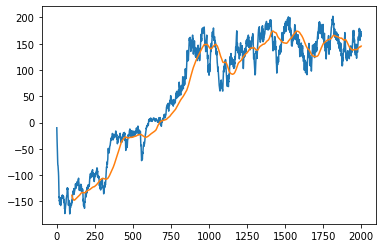

In [11]:
plt.plot(np.arange(0,2000),plot_rewards)
plt.plot(np.arange(0,2000),pd.Series(plot_rewards).rolling(100).mean())
plt.show()

### Test

In [12]:
        
def render_play(env):
    env = wrappers.Monitor(env, '/tmp/lunar-lander-6', video_callable=lambda episode_id: True,force=True)
    max_episodes = 20
    max_steps = 9000
    for ep in range(max_episodes):
        state=env.reset()
        current_reward = 0
        print("episode number = ",ep)
        for step in range(max_steps):
            #print(type(state))
            state = torch.from_numpy(state).float().unsqueeze(0)
            
            policy_softmax = p_net(state)
            
            policy_softmax = p_net.forward(state)
            
            #Sample next action with current stochastic policy
            
            dist_obj = Categorical(policy_softmax)
            action = dist_obj.sample()
            state,reward,done,_ = env.step(action.item())
            current_reward += reward
            if done:
                break
        print("Reward = ",current_reward)

In [13]:
# See agent in action on different env seed (perfomance maybe bad in some episodes*)
env = gym.make('LunarLander-v2')
env.seed(203)
render_play(env)
env.close()

episode number =  0
Reward =  280.829550136345
episode number =  1
Reward =  255.98444725443008
episode number =  2
Reward =  255.9316935599952
episode number =  3
Reward =  256.6205875439325
episode number =  4
Reward =  22.189455275640555
episode number =  5
Reward =  233.20485724254482
episode number =  6
Reward =  -201.87405204223595
episode number =  7
Reward =  228.48498992998336
episode number =  8
Reward =  237.65472066756797
episode number =  9
Reward =  211.06045972474678
episode number =  10
Reward =  -29.31167449814454
episode number =  11
Reward =  260.3372162469568
episode number =  12
Reward =  250.20996310142368
episode number =  13
Reward =  201.26934205814308
episode number =  14
Reward =  235.9691922720375
episode number =  15
Reward =  267.20388408327364
episode number =  16
Reward =  239.08434153116917
episode number =  17
Reward =  269.23908421189884
episode number =  18
Reward =  259.8437263389758
episode number =  19
Reward =  253.6935681448371
